In [0]:
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import numpy as np
import seaborn as sns
from fbprophet.diagnostics import cross_validation, performance_metrics


In [0]:
orders=pd.read_csv('./Orders_counts.csv')

In [0]:
orders.head(  )

,Creation,count(orders.name)
0,2019-10-24 10,47
1,2019-10-24 09,32
2,2019-10-24 08,28
3,2019-10-24 07,33
4,2019-10-24 06,28


In [0]:
pd.to_datetime(orders.Creation ).head()

0   2019-10-24 10:00:00
1   2019-10-24 09:00:00
2   2019-10-24 08:00:00
3   2019-10-24 07:00:00
4   2019-10-24 06:00:00
Name: Creation, dtype: datetime64[ns]

In [0]:
orders.dtypes

Creation              object
count(orders.name)     int64
dtype: object

In [0]:
orders.isna().sum()

Creation              0
count(orders.name)    0
dtype: int64

In [0]:
orders.head(20)

,Creation,count(orders.name)
0,2019-10-24 10,47
1,2019-10-24 09,32
2,2019-10-24 08,28
3,2019-10-24 07,33
4,2019-10-24 06,28
5,2019-10-24 05,18
6,2019-10-24 04,17
7,2019-10-24 03,18
8,2019-10-24 02,20
9,2019-10-24 01,38


In [0]:
orders.describe()

,count(orders.name)
count,14000.000000
mean,26.735429
std,23.530405
min,1.000000
25%,10.000000
50%,20.000000
75%,36.000000
max,382.000000


In [0]:
orders.set_index('Creation',inplace=True)

In [0]:
orders.rename(columns={"count(orders.name)": "orders_count"},inplace=True)

In [0]:
orders.index = pd.to_datetime(orders.index)

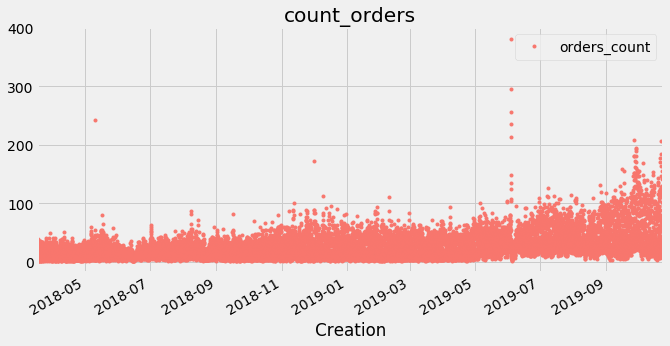

In [0]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
orders.plot(style='.', figsize=(10,5), color=color_pal[0], title='count_orders')

In [0]:
orders.head()

,orders_count
Creation,
2019-10-24 10:00:00,47
2019-10-24 09:00:00,32
2019-10-24 08:00:00,28
2019-10-24 07:00:00,33
2019-10-24 06:00:00,28


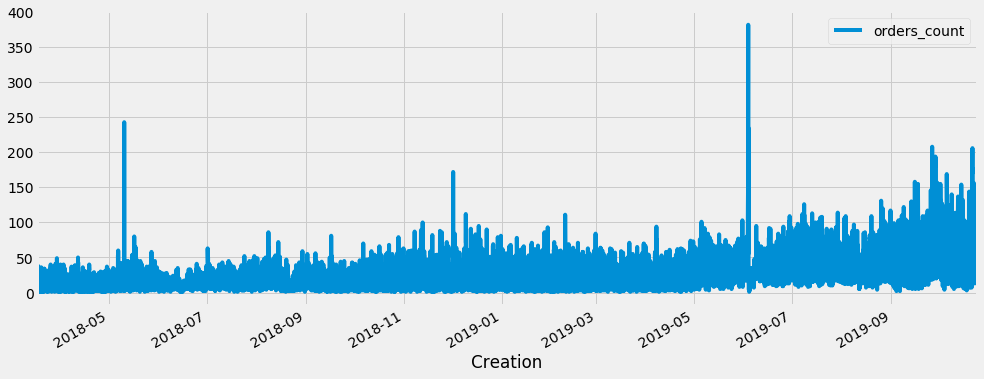

In [0]:
orders.plot(figsize=(15, 6))
plt.show()

In [0]:
def create_features(df, label=None):
    """
    Creates time series data enrichment
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(orders, label='orders_count')

features_and_target = pd.concat([X, y], axis=1)


In [0]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,orders_count
Creation,,,,,,,,,
2019-10-24 10:00:00,10,3,4,10,2019,297,24,43,47
2019-10-24 09:00:00,9,3,4,10,2019,297,24,43,32
2019-10-24 08:00:00,8,3,4,10,2019,297,24,43,28
2019-10-24 07:00:00,7,3,4,10,2019,297,24,43,33
2019-10-24 06:00:00,6,3,4,10,2019,297,24,43,28


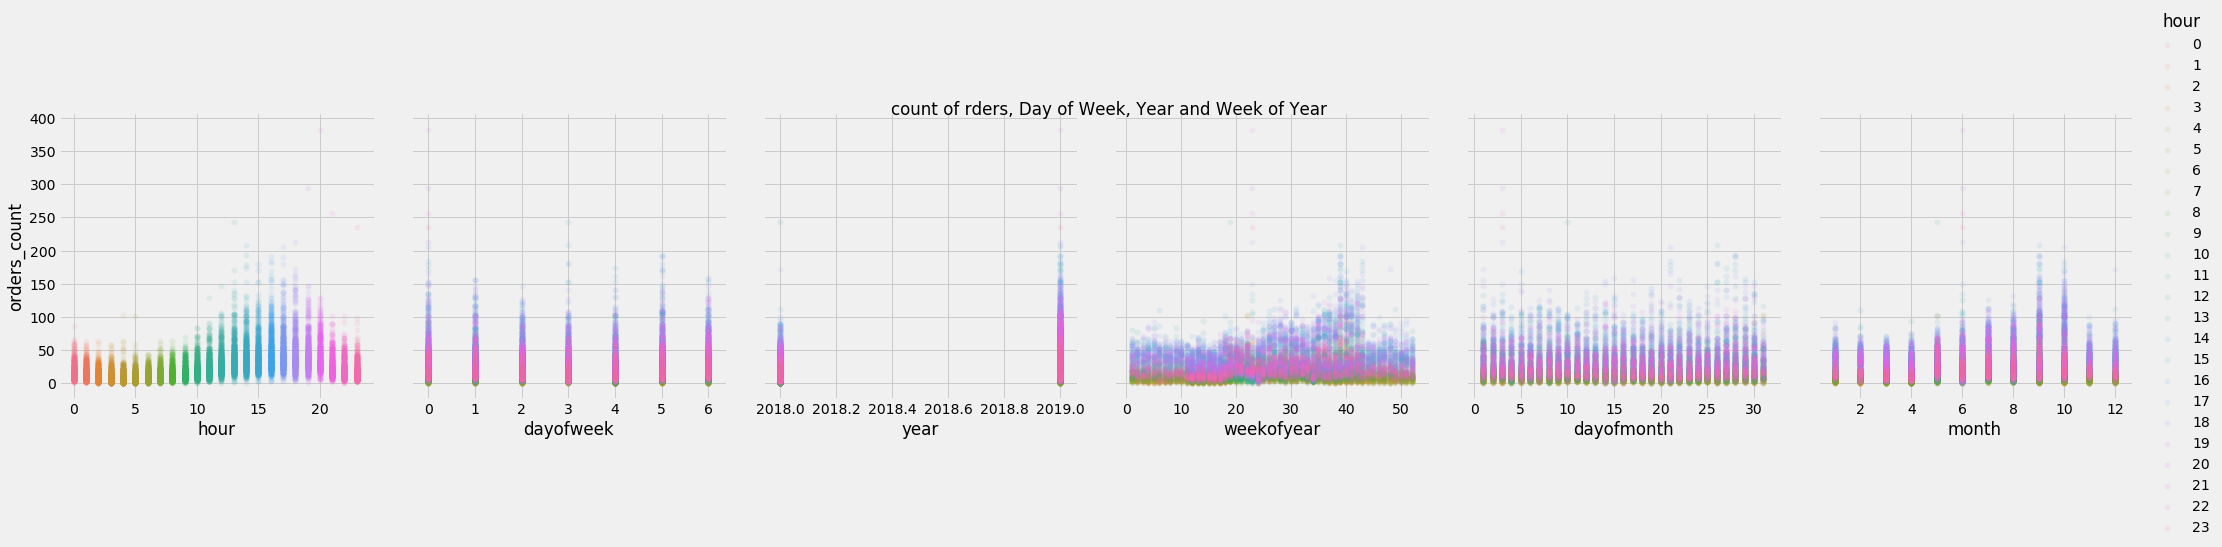

In [0]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour' ,'dayofweek','year','weekofyear','dayofmonth','month'],
             y_vars='orders_count',
             height=5,
             plot_kws={'alpha':0.1, 'linewidth':0}
            )
plt.suptitle('count of rders, Day of Week, Year and Week of Year')
plt.show()

In [0]:
split_date = '08-01-2019'
count_train = orders.loc[orders.index <= split_date].copy()
count_test = orders.loc[orders.index > split_date].copy()

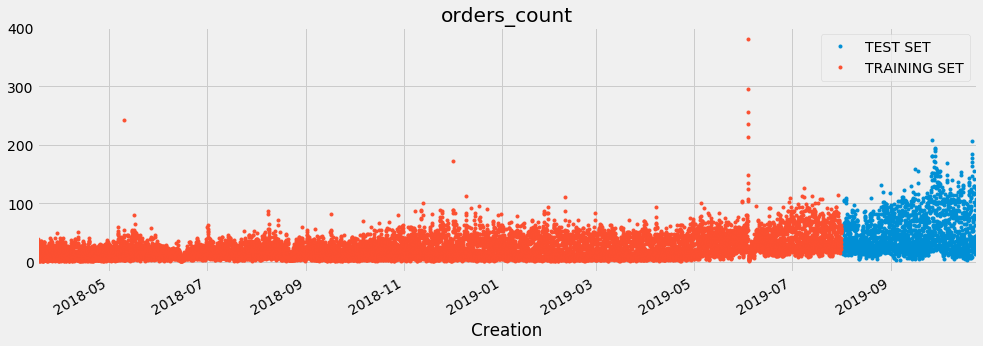

In [0]:
_ = count_test \
    .rename(columns={'orders_count': 'TEST SET'}) \
    .join(count_train.rename(columns={'orders_count': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='orders_count', style='.')

In [0]:
count_train.reset_index().rename(columns={'Creation':'ds', 'orders_count':'y'}).head()


,ds,y
0,2019-08-01 00:00:00,21
1,2019-07-31 23:00:00,26
2,2019-07-31 22:00:00,40
3,2019-07-31 21:00:00,34
4,2019-07-31 20:00:00,51


In [0]:
# Setup and train model
model = Prophet( )
model.fit(count_train.reset_index().rename(columns={'Creation':'ds', 'orders_count':'y'}))

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [0]:
count_test_fcst = model.predict(df=count_test.reset_index().rename(columns={'Creation':'ds'}))

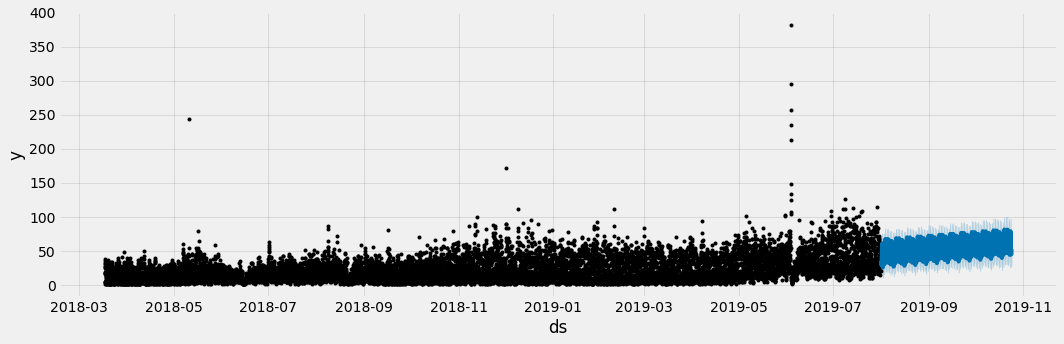

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(count_test_fcst, ax=ax)

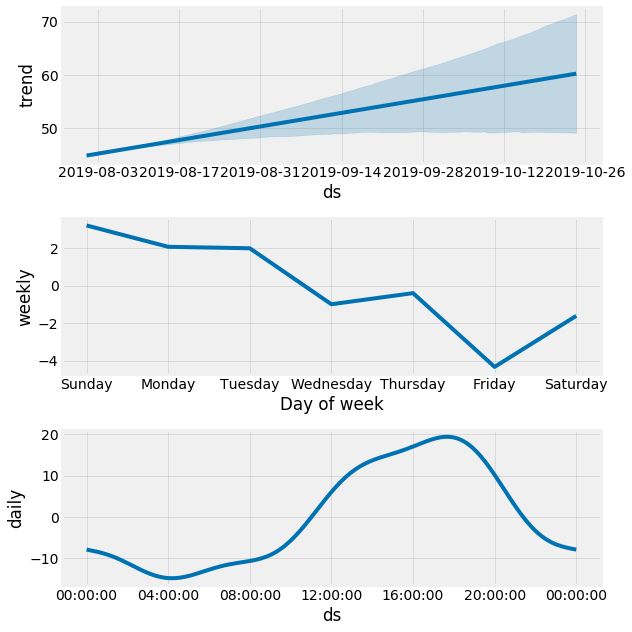

In [0]:
fig = model.plot_components(count_test_fcst)

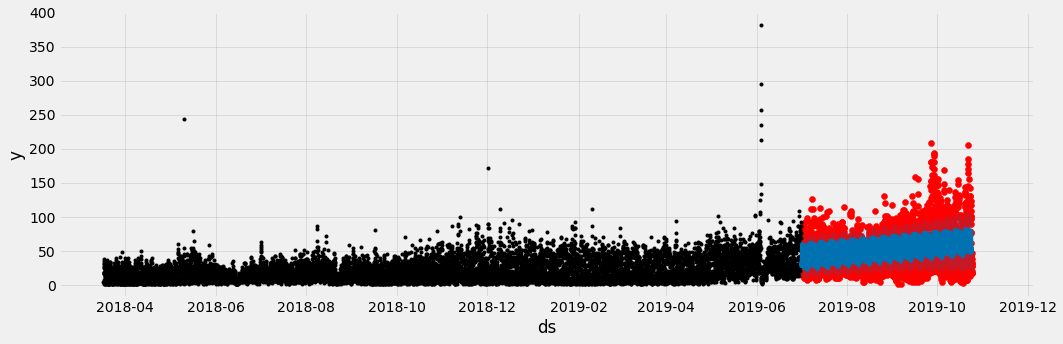

In [0]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(count_test.index, count_test['orders_count'], color='r')
fig = model.plot(count_test_fcst, ax=ax)

In [0]:
cv = cross_validation(model, horizon='30 days')
df_p = performance_metrics(cv)
df_p.head()

INFO:fbprophet:Making 26 forecasts with cutoffs between 2018-06-22 00:00:00 and 2019-07-02 00:00:00


,horizon,mse,rmse,mae,mape,coverage
0,3 days 01:00:00,284.739535,16.874227,8.593395,0.744804,0.771622
1,3 days 02:00:00,284.884632,16.878526,8.594279,0.738458,0.771003
2,3 days 03:00:00,284.665126,16.872022,8.587901,0.742397,0.771940
3,3 days 04:00:00,284.898000,16.878922,8.597167,0.748805,0.772197
4,3 days 05:00:00,284.782803,16.875509,8.591643,0.748773,0.773312


In [0]:
df_p.shape

(648, 6)

In [0]:
orders.loc[orders.index>('2018-08-01'),:].tail()

,orders_count
Creation,
2018-08-01 05:00:00,10
2018-08-01 04:00:00,7
2018-08-01 03:00:00,17
2018-08-01 02:00:00,8
2018-08-01 01:00:00,12


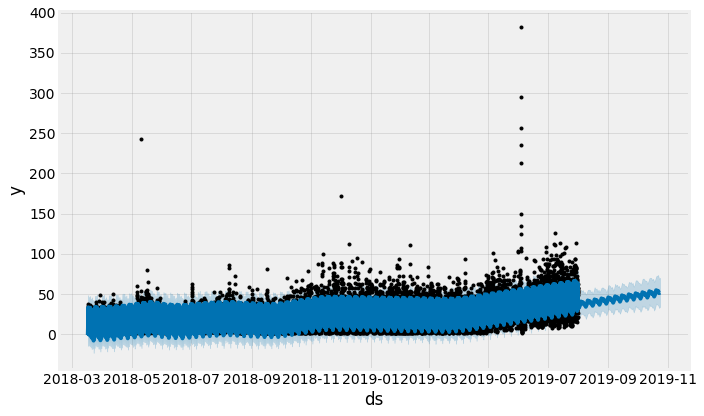

In [0]:
future = model.make_future_dataframe(periods=72, freq='H')
fcst = model.predict(future)
fig = model.plot(fcst)

In [0]:
fcst.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
12064,2019-10-20,59.433969,38.182747,72.128539,49.014640,70.303123,-4.640275,-4.640275,-4.640275,-7.858083,-7.858083,-7.858083,3.217808,3.217808,3.217808,0.0,0.0,0.0,54.793694
12065,2019-10-21,59.616053,36.949946,72.825860,48.976422,70.662410,-5.778510,-5.778510,-5.778510,-7.858083,-7.858083,-7.858083,2.079573,2.079573,2.079573,0.0,0.0,0.0,53.837543
12066,2019-10-22,59.798137,36.359932,73.667807,48.861393,70.955728,-5.856748,-5.856748,-5.856748,-7.858083,-7.858083,-7.858083,2.001335,2.001335,2.001335,0.0,0.0,0.0,53.941390
12067,2019-10-23,59.980221,32.683693,69.078242,48.864535,71.220077,-8.841339,-8.841339,-8.841339,-7.858083,-7.858083,-7.858083,-0.983255,-0.983255,-0.983255,0.0,0.0,0.0,51.138883
12068,2019-10-24,60.162305,34.035750,70.207313,48.887916,71.576148,-8.248419,-8.248419,-8.248419,-7.858083,-7.858083,-7.858083,-0.390336,-0.390336,-0.390336,0.0,0.0,0.0,51.913886
